# Homework w07d04 - DBScan Clustering

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') 
from sklearn import datasets

from math import radians, cos, sin, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### 1. Read in the following CSV file containing the outgoing UK postcodes together with their coordinates of longitude and latitude

In [2]:
X = pd.read_csv('https://www.freemaptools.com/download/outcode-postcodes/postcode-outcodes.csv')

In [3]:
X.drop(X.index[(X.latitude==0) | (X.longitude ==0)],inplace=True)

#### 2. Load the following function. It calculates the distance between any points on the Earth's surface specified by their longitude and latitude in degrees.

In [4]:
def haversine(lonlat1, lonlat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2.)**2 + cos(lat1) * cos(lat2) * sin(dlon/2.)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [5]:
X.shape

(2975, 4)

#### 3. Calculate the distance matrix between each pair of points

In [6]:
my_metric = pdist(X.ix[:,['latitude','longitude']], (lambda u,v: haversine(u,v)))

In [7]:
distance_matrix = squareform(my_metric)

In [8]:
X.head()

,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089
2,4,AB12,57.10100,-2.11060
3,5,AB13,57.10801,-2.23776
4,6,AB14,57.10076,-2.27073


In [9]:
print distance_matrix.shape

(2975, 2975)


#### 4.a) Do DBScan clustering on the distance matrix with the precomputed metric. Adjust the values of eps and min_samples to obtain a suitable number of clusters

In [10]:
db = DBSCAN(eps=10, min_samples=20, metric='precomputed')  # using "precomputed" as recommended by @Anony-Mousse
y_db = db.fit_predict(distance_matrix) # do your fit on the distance matrix

In [11]:
X['cluster'] = y_db 

In [12]:
X.head()

,id,postcode,latitude,longitude,cluster
0,2,AB10,57.13514,-2.11731,-1
1,3,AB11,57.13875,-2.09089,-1
2,4,AB12,57.10100,-2.11060,-1
3,5,AB13,57.10801,-2.23776,-1
4,6,AB14,57.10076,-2.27073,-1


In [13]:
X['cluster'] = X.cluster

In [14]:
print len(X.cluster.unique())
X.cluster.value_counts()

13


-1     1983
 4      379
 0      103
 3       89
 7       83
 1       77
 10      64
 8       59
 11      35
 9       34
 5       28
 2       21
 6       20
Name: cluster, dtype: int64

#### 4.b) Produce a scatter plot of the angular variables with points coloured according to their cluster label

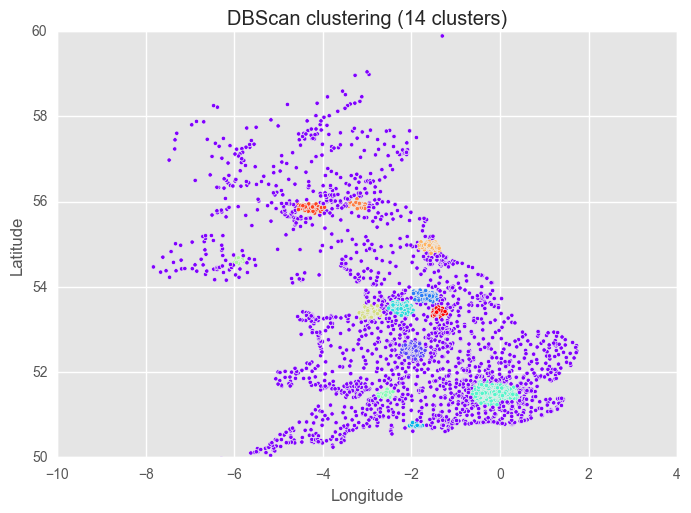

In [15]:
from matplotlib import cm
plt.scatter(X['longitude'], X['latitude'], c=X['cluster'],cmap = cm.get_cmap('rainbow'),s=10)
plt.ylim([50,60])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBScan clustering (14 clusters)')
plt.show()

#### 5.a) Now use hierarchical clustering using the matrix of latitude and longitude values as an input. 

Hints: 

In the linkage function, apart from the data matrix, you can pass the optional argument
metric=(lambda u,v: haversine(u,v)).

To calculate the cophenet correlation, you can use pdist(X.ix[:,['latitude','longitude']], (lambda u,v: haversine(u,v))) as distance measure.

In [16]:
Z = linkage(distance_matrix,'average')
c, coph_dists = cophenet(Z,my_metric)

print c
print len(coph_dists)
print coph_dists.mean()

0.80408996952
4423825
10567.7638873


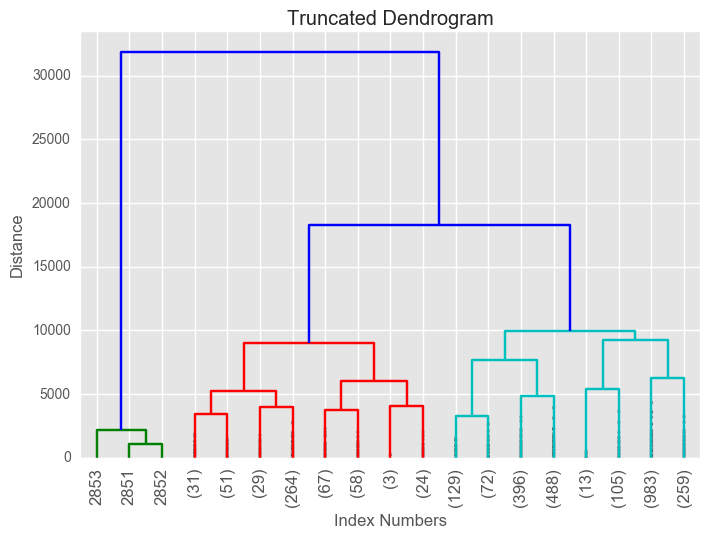

In [17]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='level',  
    p=4,  
    show_leaf_counts=True,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    color_threshold = 10000
)
plt.show()

#### 5.b) Tune the threshold to obtain a suitable number of clusters. Produce a scatter plot of latitude and longitude values and colour the points according to their cluster labels.

In [18]:
clusters = fcluster(Z, 14, criterion='maxclust')
print len(set(clusters))

14


In [19]:
X['cluster_hier'] = clusters
X.cluster_hier.value_counts()

12    983
8     488
7     396
3     293
14    221
6     201
4     125
2      82
10     80
13     38
5      27
11     25
9      13
1       3
Name: cluster_hier, dtype: int64

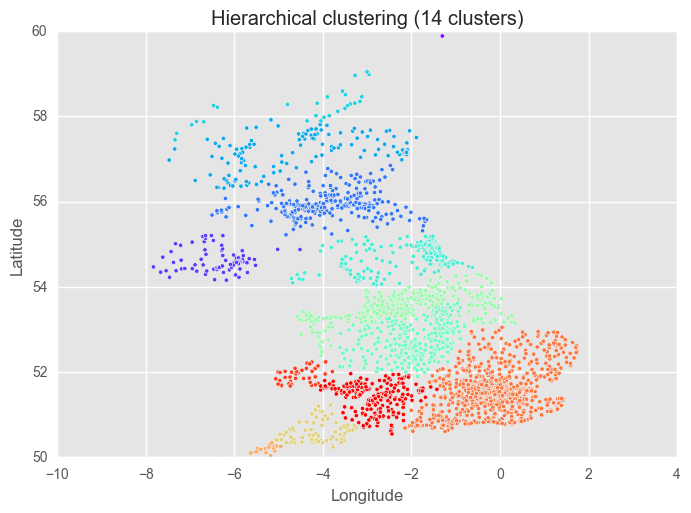

In [20]:
plt.scatter(X['longitude'], X['latitude'], c=X['cluster_hier'],
            cmap = cm.get_cmap('rainbow'),s=10)
plt.ylim([50,60])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hierarchical clustering (14 clusters)')
plt.show()

In [21]:
agg = cluster.AgglomerativeClustering(n_clusters=14, affinity='precomputed',linkage='average')
cluster_hiersk = agg.fit_predict(distance_matrix)
X['cluster_hiersk'] = cluster_hiersk
print X.cluster_hiersk.value_counts()

2     897
4     819
5     305
12    264
3     203
0     120
1      90
10     88
9      80
7      79
8      13
6       9
13      5
11      3
Name: cluster_hiersk, dtype: int64


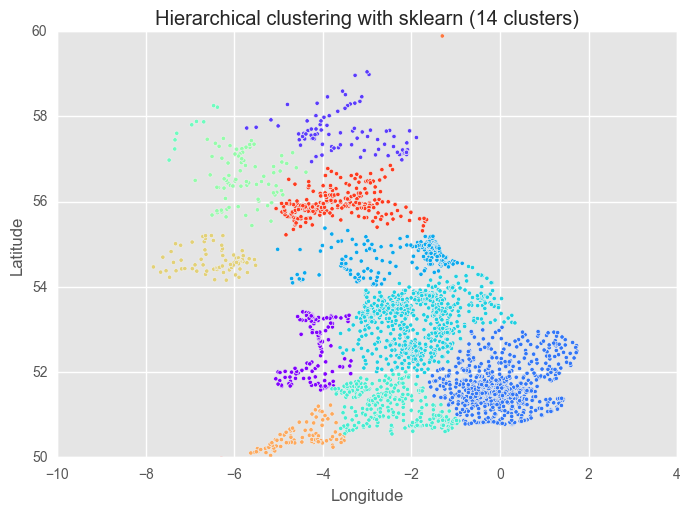

In [22]:
plt.scatter(X['longitude'], X['latitude'], c=cluster_hiersk,
            cmap = cm.get_cmap('rainbow'),s=10)
plt.ylim([50,60])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hierarchical clustering with sklearn (14 clusters)')
plt.show()

#### 6.a) Now do a kmeans fit on the distance matrix obtained above. Choose the same number of clusters that you found suitable in the previous parts.

In [23]:
k = 14
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(distance_matrix)
labels = kmeans.labels_

In [24]:
X['cluster_kmeans'] = labels
X.cluster_kmeans.value_counts()

0     526
6     310
2     307
1     277
7     270
4     248
9     212
5     205
13    169
8     123
12    111
10     96
11     82
3      39
Name: cluster_kmeans, dtype: int64

#### 6.b) Tune the threshold to obtain a suitable number of clusters. Produce a scatter plot of latitude and longitude values and colour the points according to their cluster labels.

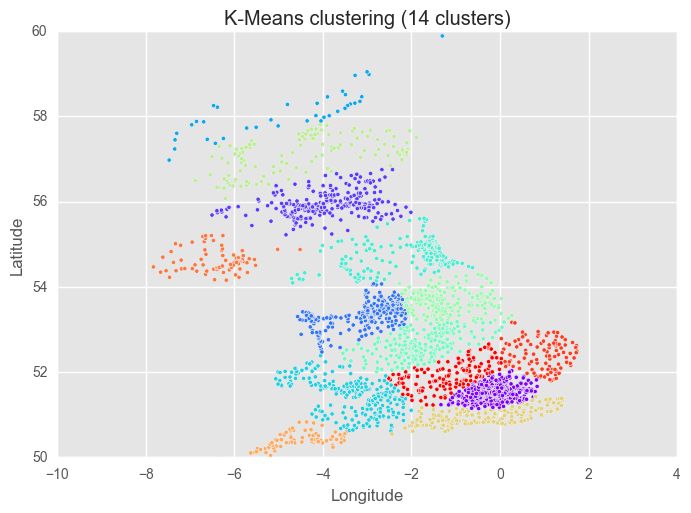

In [25]:
plt.scatter(X['longitude'], X['latitude'], c=X['cluster_kmeans'],
            cmap = cm.get_cmap('rainbow'),s=10)
plt.ylim([50,60])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means clustering (14 clusters)')
plt.show()

#### 7. Describe in one sentence the different results obtained with the various clustering algorithms.

In [26]:
X.head()

,id,postcode,latitude,longitude,cluster,cluster_hier,cluster_hiersk,cluster_kmeans
0,2,AB10,57.13514,-2.11731,-1,4,1,8
1,3,AB11,57.13875,-2.09089,-1,4,1,8
2,4,AB12,57.10100,-2.11060,-1,4,1,8
3,5,AB13,57.10801,-2.23776,-1,4,1,8
4,6,AB14,57.10076,-2.27073,-1,4,1,8


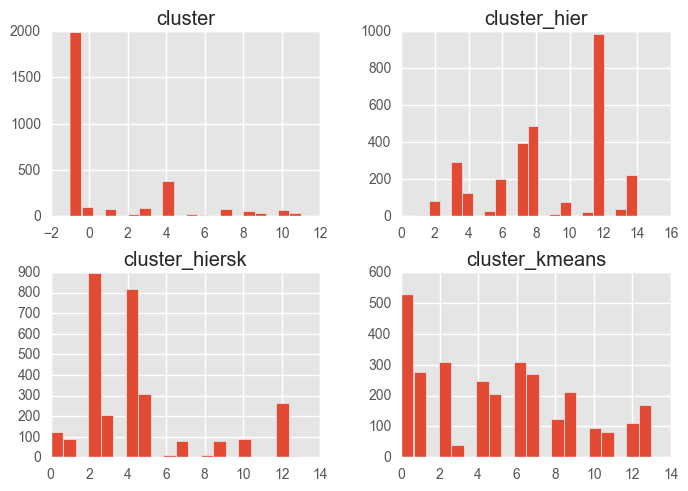

In [27]:
X[['cluster_hier','cluster_kmeans','cluster','cluster_hiersk']].hist(bins=20)
plt.show()

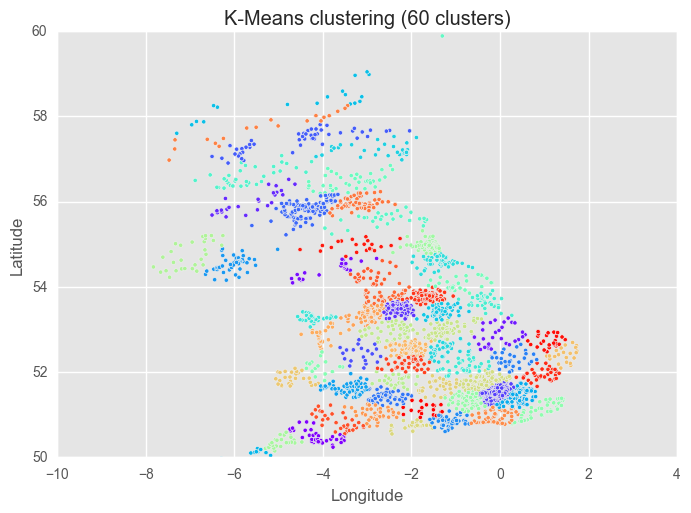

In [39]:
k = 60
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(distance_matrix)
labels = kmeans.labels_
plt.scatter(X['longitude'], X['latitude'], c=labels,
            cmap = cm.get_cmap('rainbow'),s=10)
plt.ylim([50,60])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means clustering ({0} clusters)'.format(k))
plt.show()

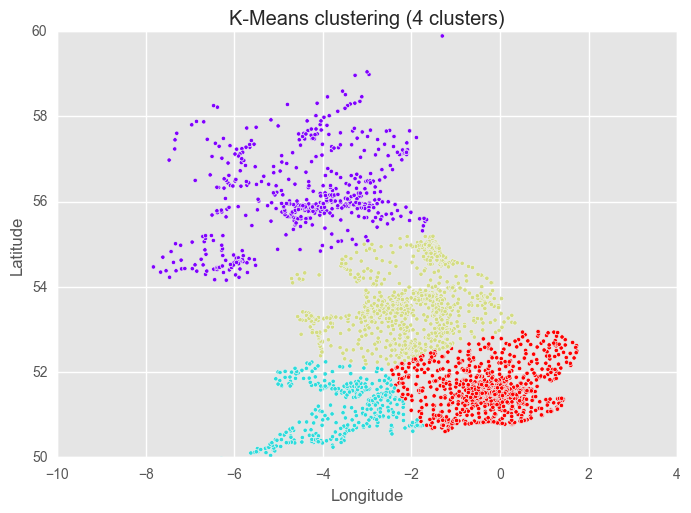

In [40]:
k = 4
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(distance_matrix)
labels = kmeans.labels_
plt.scatter(X['longitude'], X['latitude'], c=labels,
            cmap = cm.get_cmap('rainbow'),s=10)
plt.ylim([50,60])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means clustering ({0} clusters)'.format(k))
plt.show()